# Churn Prediction

The dataset used in this project contains information about customer transactions and demographics. The original dataset is from Kaggle and can be found [here](https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets). It has been modified for the purpose of this project.

The objective is to build a predictive model that can accurately classify whether a customer will churn based on these features.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

## Data

In [2]:
# Read data
path_data = "https://github.com/pabloestradac/causalml-basics/raw/main/data/"
df = pd.read_csv(path_data + 'churn.csv')
df.describe().round(2)

,num_transactions,total_amount,avg_amount,std_amount,churn,current_age,yearly_income,total_debt,credit_score,num_credit_cards
count,1219.00,1219.00,1219.00,1219.00,1219.00,1219.00,1219.00,1219.00,1219.00,1219.00
mean,10915.43,469102.15,43.91,78.71,0.03,53.05,45117.95,58196.86,713.22,3.70
std,5607.36,292602.85,17.48,27.27,0.18,15.66,23292.43,51255.43,65.55,1.57
min,760.00,26605.34,5.34,9.71,0.00,23.00,1.00,0.00,488.00,1.00
25%,7223.50,269693.84,32.22,61.25,0.00,41.00,32075.00,18527.50,684.00,3.00
50%,9832.00,398837.16,40.72,74.25,0.00,51.00,40012.00,51984.00,715.00,4.00
75%,13349.00,597774.02,52.55,91.87,0.00,63.00,52176.50,84080.50,755.00,5.00
max,48479.00,2445773.25,147.24,279.91,1.00,101.00,280199.00,461854.00,850.00,9.00


## Using Statsmodels for Logistic Regression

In logistic regression, the dependent variable is binary, and the goal is to model the probability that the dependent variable belongs to a particular category. In this case, the dependent variable will indicate whether a customer has churned. This is

$$
P(\text{Churn} = 1 | X) = \frac{e^{\beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p}} ,
$$

where $X = (X_1, \ldots, X_p)$ are the predictors, and $\beta = (\beta_0, \ldots, \beta_p)$ are the coefficients.

The `GLM()` function from the `statsmodels` library will be used to perform logistic regression using the class of generalized linear models. Alternatively, the function `Logit()` fits a logistic regression model directly. The syntax of `GLM()` is similar to that of sm.OLS(), except that we must pass in the argument `family=sm.families.Binomial()`.

In [3]:
import patsy

model = ('num_transactions + avg_amount + std_amount + current_age + '
         'gender + np.log1p(yearly_income) + np.log1p(total_debt) + credit_score + num_credit_cards')
Xbase = patsy.dmatrix(model, df, return_type='dataframe')
y = df['churn']

In [4]:
import statsmodels.api as sm

# Linear probability model
model = sm.OLS(y, Xbase)
results = model.fit()
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1432,0.101,1.412,0.158,-0.056,0.342
gender[T.Male],0.0100,0.010,0.976,0.329,-0.010,0.030
num_transactions,-4.087e-06,9.89e-07,-4.131,0.000,-6.03e-06,-2.15e-06
avg_amount,0.0005,0.000,1.226,0.221,-0.000,0.001
std_amount,2.873e-05,0.000,0.098,0.922,-0.001,0.001
current_age,-0.0008,0.000,-2.207,0.028,-0.002,-9.25e-05
np.log1p(yearly_income),0.0081,0.008,0.967,0.334,-0.008,0.025
np.log1p(total_debt),-0.0017,0.002,-0.836,0.403,-0.006,0.002
credit_score,-0.0001,8.24e-05,-1.493,0.136,-0.000,3.86e-05
num_credit_cards,-0.0085,0.004,-2.263,0.024,-0.016,-0.001


Interpretation: one more credit card decreases the probability of churn by 0.85 percentage points.

In [5]:
# Logistic regression
model = sm.Logit(y, Xbase)
results = model.fit()
results.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.119432
         Iterations 9


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-7.6918,5.855,-1.314,0.189,-19.168,3.784
gender[T.Male],0.2546,0.335,0.759,0.448,-0.403,0.912
num_transactions,-0.0003,6.08e-05,-4.948,0.000,-0.000,-0.000
avg_amount,0.0207,0.014,1.459,0.145,-0.007,0.049
std_amount,-0.0138,0.010,-1.429,0.153,-0.033,0.005
current_age,-0.0316,0.014,-2.330,0.020,-0.058,-0.005
np.log1p(yearly_income),1.1346,0.571,1.987,0.047,0.015,2.254
np.log1p(total_debt),-0.0640,0.065,-0.989,0.322,-0.191,0.063
credit_score,-0.0032,0.003,-1.270,0.204,-0.008,0.002
num_credit_cards,-0.2526,0.140,-1.805,0.071,-0.527,0.022


Interpretation: one more credit card decreases the log-odds of churn by 0.25

In [6]:
marginal_effects = results.get_margeff()
marginal_effects.summary().tables[1]

,dy/dx,std err,z,P>|z|,[0.025,0.975]
gender[T.Male],0.0076,0.010,0.758,0.449,-0.012,0.027
num_transactions,-9.029e-06,2.02e-06,-4.471,0.000,-1.3e-05,-5.07e-06
avg_amount,0.0006,0.000,1.443,0.149,-0.000,0.001
std_amount,-0.0004,0.000,-1.413,0.158,-0.001,0.000
current_age,-0.0009,0.000,-2.272,0.023,-0.002,-0.000
np.log1p(yearly_income),0.0340,0.017,1.959,0.050,-1.25e-05,0.068
np.log1p(total_debt),-0.0019,0.002,-0.984,0.325,-0.006,0.002
credit_score,-9.59e-05,7.6e-05,-1.262,0.207,-0.000,5.3e-05
num_credit_cards,-0.0076,0.004,-1.776,0.076,-0.016,0.001


Interpretation: one more credit card decreases the probability of churn by 0.76 percentage points.

## Using Scikit-learn for Logistic Regression

Logistic regression is a special case of Generalized Linear Models (GLM) with a Binomial / Bernoulli conditional distribution and a Logit link. The numerical output of the logistic regression, which is the predicted probability, can be used as a classifier by applying a threshold (by default 0.5) to it. This is how it is implemented in scikit-learn, so it expects a categorical target, making the Logistic Regression a classifier.

This implementation can fit binary, One-vs-Rest, or multinomial logistic regression with optional $\ell_1$, $\ell_2$ or Elastic-Net regularization.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xbase, y, test_size=0.5, random_state=42)

# Fit the model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions with train data
y_pred = clf.predict(X_train)

# Confusion matrix
confusion_matrix(y_train, y_pred)

array([[590,   0],
       [ 18,   1]])

In the confusion matrix, each row represents the actual class, while each column represents the predicted class.

Out of the 19 customers who churned, the model correctly predicted only 1 of them. This is a very poor result.

In [8]:
# Evaluate the model
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       590
           1       1.00      0.05      0.10        19

    accuracy                           0.97       609
   macro avg       0.99      0.53      0.54       609
weighted avg       0.97      0.97      0.96       609



- Precision measures the proportion of positive identifications that were actually correct. It is given by $\text{TP} / (\text{TP} + \text{FP})$, where TP is the number of true positives and FP is the number of false positives. 
  - If precision is 0.6, then 60% of the customers that the model predicted to churn we actually lost.

- Recall measures the proportion of actual positives that were identified correctly. It is given by $\text{TP} / (\text{TP} + \text{FN})$, where FN is the number of false negatives. 
  - If recall is 0.7, then 70% of the customers that actually churned were identified by the model.

- The F1 score is the harmonic mean of precision and recall, and is given by $2 \times \text{Precision} \times \text{Recall} / (\text{Precision} + \text{Recall})$. 
  - If your F1 Score is high, it means your model has found a good balance between precision and recall.

- Accuracy measures the proportion of true results (both true positives and true negatives) in the population. It is given by $(\text{TP} + \text{TN}) / (\text{TP} + \text{TN} + \text{FP} + \text{FN})$. 
  - If accuracy is 0.8, then 80% of customers were correctly classified by the model.

- Macro-average calculates the metric independently for each class and then takes the average (hence treating all classes equally), whereas micro-average aggregates the contributions of all classes to compute the average metric.

In [9]:
# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       587
           1       0.00      0.00      0.00        23

    accuracy                           0.96       610
   macro avg       0.48      0.50      0.49       610
weighted avg       0.93      0.96      0.94       610



As we have seen previously, the training error rate is often overly optimistic — it tends to underestimate the test error rate. In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held out data.

In [10]:
# Confusion matrix
confusion_matrix(y_test, y_pred) 

array([[587,   0],
       [ 23,   0]])

This gets worse when we use the test set. The model is not able to predict any of the customers who churned.

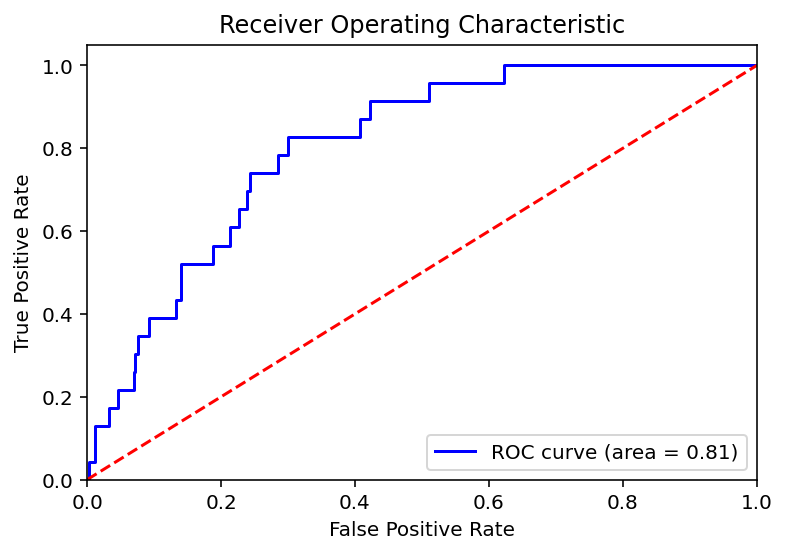

In [11]:
# ROC curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show() 


The ROC curve is drawn by calculating the true positive rate (TPR) and false positive rate (FPR) at every possible threshold (in practice, at selected intervals), then graphing TPR over FPR. 

The area under the ROC curve (AUC) is a measure of the accuracy of the model. AUC represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative. An AUC of 0.5 indicates that the model is no better than random, while an AUC of 1 indicates that the model is perfect.

## Linear Discriminant Analysis



In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit the model
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       587
           1       0.00      0.00      0.00        23

    accuracy                           0.96       610
   macro avg       0.48      0.50      0.49       610
weighted avg       0.93      0.96      0.94       610



## K-Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Fit KNN model
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       587
           1       0.00      0.00      0.00        23

    accuracy                           0.96       610
   macro avg       0.48      0.50      0.49       610
weighted avg       0.93      0.96      0.94       610



In [14]:
# Tuning KNN model
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 20)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

# Best parameters
print("Best parameters for KNN:", knn_cv.best_params_['n_neighbors'])
print("Best cross-validation score for KNN:", round(knn_cv.best_score_, 2))

# Make predictions with the best KNN model
y_pred = knn_cv.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

Best parameters for KNN: 2
Best cross-validation score for KNN: 0.97
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       587
           1       0.00      0.00      0.00        23

    accuracy                           0.96       610
   macro avg       0.48      0.50      0.49       610
weighted avg       0.93      0.96      0.94       610



## Support Vector Machines

In [15]:
# Fit Support Vector Machine model
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(X_train, y_train)

# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       587
           1       0.00      0.00      0.00        23

    accuracy                           0.96       610
   macro avg       0.48      0.50      0.49       610
weighted avg       0.93      0.96      0.94       610

